# BFSI RAG Capstone with LangGraph and GPT-5

This notebook implements a step-by-step capstone project for the BFSI domain, using a small Excel dataset and three scenarios:

1. Read a BFSI sample Excel file using LangChain tools, build an Agent for exploratory analysis, generate a bar plot, and produce a summary report.
2. Insert the Excel data into a Chroma vector database and implement a Retrieval-Augmented Generation (RAG) flow using a GPT-5 agent.
3. Extend the solution with a Model Context Protocol (MCP) Server and Client to manage tools, then wire it into a LangGraph RAG pipeline for an enterprise-grade solution.
4. Provide FastAPI containerization and deployment scaffolding (Docker/Azure) to run the solution as a service.

All code is written with clear, incremental steps. You can adapt the components to your enterprise datasets and infrastructure.

## 0. Environment Setup

Install the required packages and configure environment variables.

- Python 3.10+ suggested
- Create a virtual environment, then install dependencies
- Add your OpenAI API key as `OPENAI_API_KEY`

Suggested commands:
```
python -m venv bfsi
source bfsi/bin/activate  # or .\bfsi\Scripts\activate on Windows
pip install -r requirements.txt
export OPENAI_API_KEY="sk-..."
```

In [1]:
print("welcome to bfsI capstone")

welcome to bfsI capstone


In [ ]:
file_path='/Users/surendra/gen_ai/ilink/bfsi_capstone/data/bfsi_sample.xlsx'

In [4]:
import pandas as pd

file_path = 'data/bfsi_sample.xlsx'

df = pd.read_excel(file_path)
print(df.head(10))

  TransactionID CustomerID AccountType   Region             Sector  \
0       TXN1000   CUST2000     Savings     West  Wealth Management   
1       TXN1001   CUST2001     Savings    North  Wealth Management   
2       TXN1002   CUST2002  CreditCard     East  Corporate Banking   
3       TXN1003   CUST2003     Current     East  Wealth Management   
4       TXN1004   CUST2004     Current  Central     Retail Banking   
5       TXN1005   CUST2005     Current     East           Payments   
6       TXN1006   CUST2006     Savings    North  Corporate Banking   
7       TXN1007   CUST2007     Savings     West           Payments   
8       TXN1008   CUST2008        Loan  Central  Corporate Banking   
9       TXN1009   CUST2009     Savings    North  Corporate Banking   

      TxnDate  AmountINR    Channel RiskLevel      Description  
0  2023-10-20  217665.24        ATM       Low    Fund transfer  
1  2024-06-26  227134.99  MobileApp       Low      EMI payment  
2  2023-10-13  476931.06  MobileAp

In [5]:
df.columns

Index(['TransactionID', 'CustomerID', 'AccountType', 'Region', 'Sector',
       'TxnDate', 'AmountINR', 'Channel', 'RiskLevel', 'Description'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  30 non-null     object 
 1   CustomerID     30 non-null     object 
 2   AccountType    30 non-null     object 
 3   Region         30 non-null     object 
 4   Sector         30 non-null     object 
 5   TxnDate        30 non-null     object 
 6   AmountINR      30 non-null     float64
 7   Channel        30 non-null     object 
 8   RiskLevel      30 non-null     object 
 9   Description    30 non-null     object 
dtypes: float64(1), object(9)
memory usage: 2.5+ KB


In [7]:
df.shape

(30, 10)

In [8]:
df.describe()

,AmountINR
count,30.000000
mean,259723.025667
std,161520.296380
min,785.660000
25%,136440.415000
50%,257977.210000
75%,430472.255000
max,476931.060000


In [11]:
df.columns

Index(['TransactionID', 'CustomerID', 'AccountType', 'Region', 'Sector',
       'TxnDate', 'AmountINR', 'Channel', 'RiskLevel', 'Description'],
      dtype='object')

<Axes: xlabel='CustomerID'>

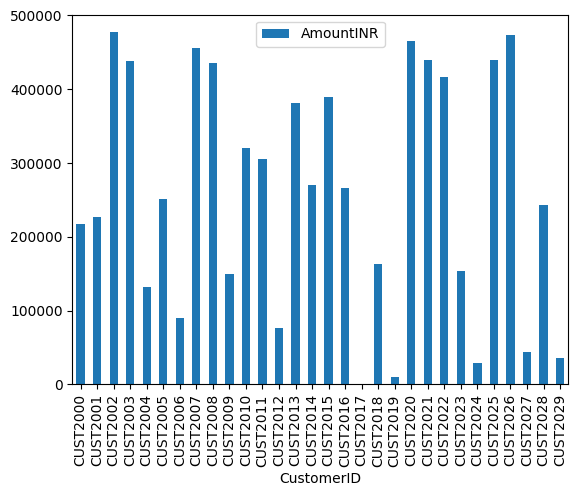

In [12]:
df.plot(x='CustomerID', y='AmountINR', kind='bar')

In [2]:
import os
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True, parents=True)
print("Data directory:", DATA_DIR.resolve())

# If running outside this environment, copy your Excel file into ./data
SAMPLE_XLSX = DATA_DIR / "bfsi_sample.xlsx"

# If the sample file is not present, you can generate one using pandas, or copy from the provided files
print("Expecting sample file at:", SAMPLE_XLSX.resolve())

Data directory: /Users/surendra/gen_ai/ilink/bfsi_capstone/data
Expecting sample file at: /Users/surendra/gen_ai/ilink/bfsi_capstone/data/bfsi_sample.xlsx


## 1. Scenario 1 — Read BFSI Excel with LangChain, Analyze via Agent, Plot, and Summarize

Goals:
- Load the Excel file into a DataFrame
- Wrap it with LangChain tools
- Build a lightweight LangGraph agent that can decide when to use the analysis tool
- Produce a bar plot of aggregated metrics
- Generate a concise summary report in Markdown

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel(SAMPLE_XLSX)
df.head()

,TransactionID,CustomerID,AccountType,Region,Sector,TxnDate,AmountINR,Channel,RiskLevel,Description
0,TXN1000,CUST2000,Savings,West,Wealth Management,2023-10-20,217665.24,ATM,Low,Fund transfer
1,TXN1001,CUST2001,Savings,North,Wealth Management,2024-06-26,227134.99,MobileApp,Low,EMI payment
2,TXN1002,CUST2002,CreditCard,East,Corporate Banking,2023-10-13,476931.06,MobileApp,High,EMI payment
3,TXN1003,CUST2003,Current,East,Wealth Management,2024-05-20,437988.54,POS,High,Cash withdrawal
4,TXN1004,CUST2004,Current,Central,Retail Banking,2024-06-22,132062.83,ATM,Low,Utility payment


### 1.1 Create a Pandas analysis tool

This tool exposes a few safe aggregation functions for the agent to call. You can extend it with more domain logic.

In [4]:
from typing import Literal, Optional
import io

def aggregate_metric(df: pd.DataFrame, group_col: str, metric_col: str, agg: Literal["sum", "mean", "count"]="sum", top_k: int=10):
    if group_col not in df.columns or metric_col not in df.columns:
        raise ValueError("Invalid columns for aggregation")
    grouped = None
    if agg == "sum":
        grouped = df.groupby(group_col)[metric_col].sum().sort_values(ascending=False).head(top_k)
    elif agg == "mean":
        grouped = df.groupby(group_col)[metric_col].mean().sort_values(ascending=False).head(top_k)
    elif agg == "count":
        grouped = df.groupby(group_col)[metric_col].count().sort_values(ascending=False).head(top_k)
    else:
        raise ValueError("Unsupported aggregation")
    return grouped.reset_index()

### 1.2 Build a simple LangGraph agent

The agent has access to:
- A planner using GPT-5
- A tool node that runs `aggregate_metric`
- A reporter that returns either data or a plot and a short summary

Note: Replace `gpt-5` with the current model name in your environment if needed.

Plot saved at: outputs/scenario1_bar.png
Summary saved at: outputs/scenario1_report.md


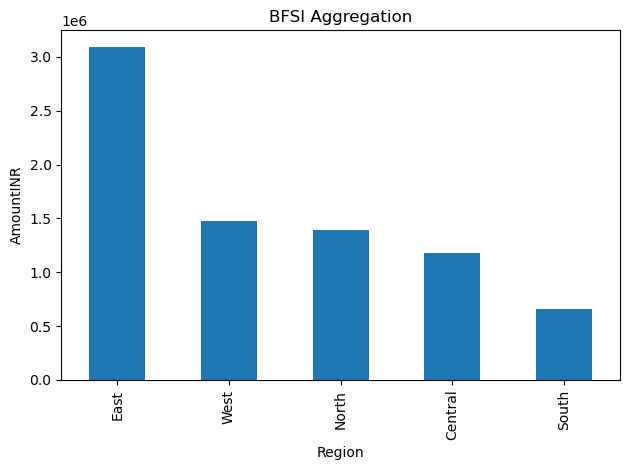

In [14]:
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any

from langchain_openai import ChatOpenAI

class AgentState(TypedDict, total=False):
    query: str
    plan: str
    tool_args: Dict[str, Any]
    result_table: Any
    plot_path: str
    summary_md: str

# LLM (Planner/Reporter)
llm = ChatOpenAI(model="gpt-5", temperature=0)

def plan_node(state: AgentState) -> AgentState:
    prompt = f"""You are a BFSI data analysis planner.
User question: {state.get('query')}
Choose one group column from {list(df.columns)} and one metric from ['AmountINR'].
Decide an aggregation among ['sum','mean','count'] and return a JSON with keys: group_col, metric_col, agg, top_k.
"""
    resp = llm.invoke(prompt)
    # naive parse; in practice, add robust JSON parsing
    import json, re
    match = re.search(r"\{[\s\S]*\}", resp.content)
    tool_args = {"group_col":"Region","metric_col":"AmountINR","agg":"sum","top_k":5}
    if match:
        try:
            tool_args = json.loads(match.group(0))
        except Exception:
            pass
    return {"plan": resp.content, "tool_args": tool_args}

def tool_node(state: AgentState) -> AgentState:
    args = state["tool_args"]
    table = aggregate_metric(df, **args)
    return {"result_table": table}

def reporter_node(state: AgentState) -> AgentState:
    table = state["result_table"]

    # Plot
    fig = plt.figure()
    table.plot(kind="bar", x=table.columns[0], y=table.columns[1], legend=False)
    plt.title("BFSI Aggregation")
    plt.xlabel(table.columns[0])
    plt.ylabel(table.columns[1])
    plot_path = "outputs/scenario1_bar.png"
    Path("outputs").mkdir(exist_ok=True, parents=True)
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150)
    plt.close(fig)

    # Summary
    top_rows = table.head(3).to_dict(orient="records")
    prompt = f"""Summarize the aggregation findings in 120-200 words for a BFSI analyst.
Input top rows: {top_rows}
Also describe what the bar chart conveys.
"""
    summary = llm.invoke(prompt).content
    # Save report
    report_md = f"# Scenario 1 Summary\n\n{summary}\n\n![Bar Plot]({plot_path})\n"
    Path("outputs").mkdir(exist_ok=True, parents=True)
    with open("outputs/scenario1_report.md", "w") as f:
        f.write(report_md)
    return {"plot_path": plot_path, "summary_md": report_md}

# Build graph
graph = StateGraph(AgentState)
graph.add_node("planner", plan_node)
graph.add_node("tool", tool_node)
graph.add_node("reporter", reporter_node)
graph.set_entry_point("planner")
graph.add_edge("planner", "tool")
graph.add_edge("tool", "reporter")
graph.add_edge("reporter", END)
agent = graph.compile()

output = agent.invoke({"query": "Find the top regions by total AmountINR and explain briefly."})
output.keys()

print("Plot saved at:", output["plot_path"])
print("Summary saved at: outputs/scenario1_report.md")


Open the generated files:
- `outputs/scenario1_bar.png`
- `outputs/scenario1_report.md`

## 2. Scenario 2 — ChromaDB RAG with GPT-5 Agent

Steps:
1. Transform each Excel row into a text chunk suitable for retrieval.
2. Create a Chroma collection and insert the chunks with embeddings.
3. Build a retriever and a LangGraph that orchestrates query, retrieve, and answer.

In [7]:
from langchain_openai import OpenAIEmbeddings
import chromadb
from chromadb.utils import embedding_functions

# Prepare documents from rows
def row_to_text(row: pd.Series) -> str:
    return (
        f"TransactionID: {row['TransactionID']}; CustomerID: {row['CustomerID']}; "
        f"AccountType: {row['AccountType']}; Region: {row['Region']}; Sector: {row['Sector']}; "
        f"TxnDate: {row['TxnDate']}; AmountINR: {row['AmountINR']}; Channel: {row['Channel']}; "
        f"RiskLevel: {row['RiskLevel']}; Description: {row['Description']}."
    )

docs = [row_to_text(r) for _, r in df.iterrows()]

client = chromadb.Client()
collection = client.get_or_create_collection("bfsi_rag")

# Use OpenAI embeddings
emb = OpenAIEmbeddings(model="text-embedding-3-large")
vectors = emb.embed_documents(docs)

ids = [f"doc_{i}" for i in range(len(docs))]
collection.upsert(ids=ids, embeddings=vectors, documents=docs)

def retrieve_top_k(query: str, k: int=5):
    qvec = emb.embed_query(query)
    res = collection.query(query_embeddings=[qvec], n_results=k)
    return [doc for doc in res["documents"][0]]

# Test retrieve
retrieve_top_k("High value transactions in Retail Banking South region", k=3)

['TransactionID: TXN1014; CustomerID: CUST2014; AccountType: Savings; Region: Central; Sector: Corporate Banking; TxnDate: 2023-08-13; AmountINR: 269919.83; Channel: POS; RiskLevel: Medium; Description: Cash withdrawal.',
 'TransactionID: TXN1003; CustomerID: CUST2003; AccountType: Current; Region: East; Sector: Wealth Management; TxnDate: 2024-05-20; AmountINR: 437988.54; Channel: POS; RiskLevel: High; Description: Cash withdrawal.',
 'TransactionID: TXN1022; CustomerID: CUST2022; AccountType: Loan; Region: North; Sector: Retail Banking; TxnDate: 2025-12-19; AmountINR: 415916.93; Channel: Branch; RiskLevel: Low; Description: Cash withdrawal.']

### 2.1 LangGraph RAG Orchestrator

Nodes:
- Planner: rewrite or refine the user question
- Retriever: fetch top-k chunks from Chroma
- Answerer: compose final answer using GPT-5 with retrieved context

In [15]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, END

class RAGState(TypedDict, total=False):
    query: str
    refined_query: str
    contexts: List[str]
    answer: str

def rag_plan(state: RAGState) -> RAGState:
    prompt = f"Rewrite the BFSI question to be retrieval-friendly: {state.get('query')}"
    refined = llm.invoke(prompt).content
    return {"refined_query": refined}

def rag_retrieve(state: RAGState) -> RAGState:
    contexts = retrieve_top_k(state["refined_query"], k=5)
    return {"contexts": contexts}

def rag_generate_answer(state: RAGState) -> RAGState:  # <-- renamed function
    ctx = "\n".join(state["contexts"])
    prompt = f"""You are a BFSI RAG agent. Use the provided context to answer.
Context:
{ctx}

Question:
{state.get('query')}

Answer with specifics grounded in the context, and note any uncertainties.
"""
    ans = llm.invoke(prompt).content
    return {"answer": ans}

# Build the graph with unique node names
rag_graph = StateGraph(RAGState)
rag_graph.add_node("plan", rag_plan)
rag_graph.add_node("retrieve", rag_retrieve)
rag_graph.add_node("responder", rag_generate_answer)  # <-- renamed node
rag_graph.set_entry_point("plan")
rag_graph.add_edge("plan", "retrieve")
rag_graph.add_edge("retrieve", "responder")
rag_graph.add_edge("responder", END)

rag = rag_graph.compile()

rag_out = rag.invoke({
    "query": "List key patterns in high-risk transactions across sectors and regions."
})
print(rag_out["answer"][:500])


Key patterns observed in high-risk transactions (based on the given records):

- Regional concentration: East accounts for 2 of 3 high-risk transactions (TXN1002, TXN1003); North has 1 (TXN1019). None in West or Central in this sample.
- Sector skew: Wealth Management has 2 high-risk events (TXN1003, TXN1019), both cash withdrawals; Corporate Banking has 1 high-risk event (TXN1002), an EMI payment. No high-risk fund transfers observed.
- Channel profile: High-risk transactions occur via MobileAp


## 3. Scenario 3 — MCP Server and Client Integration

The Model Context Protocol (MCP) allows exposing tools/services via a standard protocol so that agents can discover and use them.

We will:
- Implement a minimal MCP Server exposing two tools: `get_dataframe_metrics` and `store_plot`.
- Implement a minimal MCP Client that connects to the server and calls these tools from a LangGraph node.
- Compose the MCP tools into the RAG pipeline to support enterprise extensibility.

In [16]:
# server_mcp.py
mcp_server_code = r'''
import pandas as pd
from mcp.server import Server, Tool

df = pd.read_excel("data/bfsi_sample.xlsx")

def get_dataframe_metrics(group_col: str, metric_col: str, agg: str = "sum", top_k: int = 5):
    if agg == "sum":
        s = df.groupby(group_col)[metric_col].sum().sort_values(ascending=False).head(top_k)
    elif agg == "mean":
        s = df.groupby(group_col)[metric_col].mean().sort_values(ascending=False).head(top_k)
    elif agg == "count":
        s = df.groupby(group_col)[metric_col].count().sort_values(ascending=False).head(top_k)
    else:
        raise ValueError("Unsupported aggregation")
    return s.reset_index().to_dict(orient="records")

def store_plot(path: str, content_b64: str):
    import base64
    with open(path, "wb") as f:
        f.write(base64.b64decode(content_b64))
    return {"status": "ok", "path": path}

server = Server()
server.add_tool(Tool("get_dataframe_metrics", get_dataframe_metrics))
server.add_tool(Tool("store_plot", store_plot))

if __name__ == "__main__":
    server.serve("127.0.0.1", 8765)
'''
with open("server_mcp.py", "w") as f:
    f.write(mcp_server_code)
print("Wrote server_mcp.py")

Wrote server_mcp.py


In [17]:
# client_mcp.py
mcp_client_code = r'''
import asyncio
import base64
import io
import matplotlib.pyplot as plt
import pandas as pd
from mcp.client import Client

async def main():
    client = Client("127.0.0.1", 8765)
    await client.connect()

    metrics = await client.call_tool("get_dataframe_metrics", {
        "group_col": "Region",
        "metric_col": "AmountINR",
        "agg": "sum",
        "top_k": 5
    })
    print("Metrics:", metrics)

    # Example: generate a plot and store via MCP
    fig = plt.figure()
    df = pd.DataFrame(metrics)
    df.plot(kind="bar", x=df.columns[0], y=df.columns[1], legend=False)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format="png", dpi=150)
    plt.close(fig)
    img_b64 = base64.b64encode(buf.getvalue()).decode("utf-8")

    res = await client.call_tool("store_plot", {"path": "outputs/mcp_plot.png", "content_b64": img_b64})
    print("Store plot result:", res)
    await client.close()

if __name__ == "__main__":
    asyncio.run(main())
'''
with open("client_mcp.py", "w") as f:
    f.write(mcp_client_code)
print("Wrote client_mcp.py")

Wrote client_mcp.py


To run the MCP components locally:
1. `python server_mcp.py`
2. In another terminal, `python client_mcp.py`

Next, you can wrap MCP calls as LangGraph tool nodes and call them inside your RAG or analysis flows.

## 4. FastAPI Containerization and Deployment

This section provides a minimal FastAPI app exposing two endpoints:
- `/analyze` for Scenario 1 style aggregation and plot
- `/ask` for Scenario 2 RAG queries using Chroma

It also includes a Dockerfile blueprint and Azure deployment hints.

In [18]:
# app.py
fastapi_code = r'''
import os
import io
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from fastapi import FastAPI, Query
from fastapi.responses import JSONResponse, StreamingResponse
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import chromadb

app = FastAPI()
DATA_FILE = Path("data/bfsi_sample.xlsx")
df = pd.read_excel(DATA_FILE)

llm = ChatOpenAI(model="gpt-5", temperature=0)
emb = OpenAIEmbeddings(model="text-embedding-3-large")

client = chromadb.Client()
collection = client.get_or_create_collection("bfsi_service")
if len(collection.get(ids=[]).get("ids", [])) == 0:
    docs = [
        f"TransactionID: {r.TransactionID}; CustomerID: {r.CustomerID}; AccountType: {r.AccountType}; Region: {r.Region}; "
        f"Sector: {r.Sector}; TxnDate: {r.TxnDate}; AmountINR: {r.AmountINR}; Channel: {r.Channel}; "
        f"RiskLevel: {r.RiskLevel}; Description: {r.Description}."
        for _, r in df.iterrows()
    ]
    vectors = emb.embed_documents(docs)
    ids = [f"doc_{i}" for i in range(len(docs))]
    collection.upsert(ids=ids, embeddings=vectors, documents=docs)

@app.get("/analyze")
def analyze(group_col: str = Query("Region"), metric_col: str = Query("AmountINR"), agg: str = Query("sum"), top_k: int = Query(5)):
    if agg == "sum":
        s = df.groupby(group_col)[metric_col].sum().sort_values(ascending=False).head(top_k)
    elif agg == "mean":
        s = df.groupby(group_col)[metric_col].mean().sort_values(ascending=False).head(top_k)
    elif agg == "count":
        s = df.groupby(group_col)[metric_col].count().sort_values(ascending=False).head(top_k)
    else:
        return JSONResponse({"error": "Unsupported aggregation"}, status_code=400)

    # Return data
    data = s.reset_index().to_dict(orient="records")
    # Also render a chart
    fig = plt.figure()
    s.reset_index().plot(kind="bar", x=group_col, y=metric_col, legend=False)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format="png", dpi=150)
    plt.close(fig)
    buf.seek(0)
    return StreamingResponse(buf, media_type="image/png")

@app.get("/ask")
def ask(q: str):
    qvec = emb.embed_query(q)
    res = collection.query(query_embeddings=[qvec], n_results=5)
    ctx = "\n".join(res["documents"][0])
    prompt = f"Use the context to answer the BFSI question. Context:\n{ctx}\n\nQuestion: {q}"
    ans = llm.invoke(prompt).content
    return {"answer": ans}
'''
with open("app.py", "w") as f:
    f.write(fastapi_code)
print("Wrote app.py")

Wrote app.py


In [19]:
# Dockerfile
dockerfile = r'''
FROM python:3.11-slim

WORKDIR /app
COPY requirements.txt /app/requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

COPY data /app/data
COPY app.py /app/app.py

ENV OPENAI_API_KEY=your_key_here
EXPOSE 8000
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
'''
with open("Dockerfile", "w") as f:
    f.write(dockerfile)
print("Wrote Dockerfile")

Wrote Dockerfile


### Azure Deployment Notes

Option A: Azure Container Apps
1. Build and push the image
```
az acr build --registry <ACR_NAME> --image bfsi-rag:latest .
```
2. Create a Container App from the image and set `OPENAI_API_KEY` as a secret or environment variable.

Option B: Azure App Service (Linux Containers)
1. Push the Docker image to ACR or Docker Hub.
2. Create a Web App for Containers and set environment variables accordingly.